In [6]:
import numpy as np
import pandas as pd
import random, copy, os
random.seed(42)
np.random.seed(42)
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import Pool
import multiprocessing

In [7]:
%run helper.ipynb
%run algorithm_functions.ipynb

In [8]:
plt.rcParams['font.size'] = 14
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 19
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['lines.linewidth'] = 2.0

In [9]:
size_v, size_u, T, driver_quota = 3, 1, 3, 2
filename_append = 'quota_{}'.format(driver_quota)

In [10]:
drivers, requests = [], []
for i in range(size_u):
    drivers.append(Driver(d_id=i, driver_race='NA', driver_gender='NA', pickup_lat_bin='NA', 
                          pickup_long_bin='NA', quota=driver_quota))
for i in range(size_v):
    requests.append(Request(pickup_lat_bin=i, pickup_long_bin=i, dropoff_lat_bin=i, 
                            dropoff_long_bin=i, requests_gender=i, requests_race=i, 
                            arrival_rate=1, distance=1)) # unweighted graph
set_unique_ids(drivers)
set_unique_ids(requests)

In [11]:
probability_matrix = np.full((size_u, size_v), -1, dtype=float) # drivers x requests
profit_matrix = np.zeros((size_u, size_v), dtype=float)

In [12]:
for i in range(size_u):
    for j in range(size_v):
        # An edge exists with probability of 1 for j==0 and with a probability = 0.05 otherwise
        probability_matrix[i, j] = 1 if j==0 else 0.25
        profit_matrix[i, j] = requests[j].distance

In [13]:
probability_matrix, profit_matrix

(array([[1.  , 0.25, 0.25]]), array([[1., 1., 1.]]))

In [14]:
r_vs = []
for r in requests:
    r_vs.append(r.arrival_rate)
min(r_vs), max(r_vs)

in_degree_v = []
for i in range(len(requests)):
    in_degree_v.append(np.count_nonzero(probability_matrix[:,i] != -1))

in_degree_u = []
for i in range(len(drivers)):
    in_degree_u.append(np.count_nonzero(probability_matrix[i,:] != -1))

print ("Drivers' in-degree, average: {}, min: {}, max: {}\nRiders' in-degree, average: {}, min: {}, max: {}"\
       .format(np.mean(in_degree_u), min(in_degree_u), max(in_degree_u), 
               np.mean(in_degree_v), min(in_degree_v), max(in_degree_v)))

Drivers' in-degree, average: 3.0, min: 3, max: 3
Riders' in-degree, average: 1.0, min: 1, max: 1


In [15]:
print ("Drivers (|U|): {}, Requests (T): {}, Request Types (|V|): {}".format(len(drivers), 
                                                                       calculate_T(requests), len(requests)))

Drivers (|U|): 1, Requests (T): 3, Request Types (|V|): 3


In [16]:
from cvxopt.base import matrix as m
from cvxopt import solvers
from cvxopt.modeling import op, dot, variable, max, min

In [17]:
x_f = variable(np.count_nonzero(probability_matrix != -1))
profit, c = get_profit_objective(x_f, probability_matrix, profit_matrix)

In [18]:
x_fair = variable(np.count_nonzero(probability_matrix != -1))
fairness = get_fairness_objective(x_fair, probability_matrix, requests)

In [19]:
def get_inequalities_local(x_f, probability_matrix, requests, return_coefficients=False):
    offset = 0
    A, b = [], [] # model all inequalities as A * x <= b
    # models the inequalities 3 and 4 in the writeup
    for i in range(probability_matrix.shape[0]): # iterate over all drivers
        a1, a2 = [0] * len(x_f), [0] * len(x_f) # coefficients of inequalities
        edges_count = np.count_nonzero(probability_matrix[i] != -1)
        edges_probabilities = probability_matrix[i][np.where(probability_matrix[i] != -1)]
        assert len(edges_probabilities) == edges_count # sanity check
        a1[offset:offset + edges_count] = edges_probabilities
        a2[offset:offset + edges_count] = [1] * edges_count
        A.append(a1)
        A.append(a2)
        b.append(1.0)
        b.append(drivers[i].quota)
        offset += edges_count
    # Models the inequality -1 * x_f <= 0 for all edges
    for i in range(len(x_f)):
        a1 = [0] * len(x_f)
        a1[i] = -1
        A.append(a1)
        b.append(0.0)
    # Models inequality 5 in the writeup
    for j in range(probability_matrix.shape[1]):# iterate over all request types
        # j -> request; i-> driver
        a1 = [0] * len(x_f)
        for i in np.where(probability_matrix[:,j] != -1)[0]:
            a1[coordinate_to_index(i, j, probability_matrix)] = 1
        A.append(a1)
        b.append(requests[j].arrival_rate)
    print (len(A), len(b), len(A[0]), len(x_f))
    
    A, b = m(A).T, m(np.array(b))

    if not return_coefficients:
        inequality = (A * x_f <= b)
        return inequality
    else:
        return A, b

In [20]:
inequality = get_inequalities_local(x_f, probability_matrix, requests)

8 8 3 3


In [21]:
lp_profit = op(profit, inequality)
lp_profit.solve(solver='glpk')

In [22]:
print(x_f.value, max(x_f.value), min(x_f.value))

[ 1.00e+00]
[ 0.00e+00]
[ 0.00e+00]
 1.0 0.0


In [23]:
inequality_fairness = get_inequalities_local(x_fair, probability_matrix, requests)

8 8 3 3


In [24]:
lp_fairness = op(fairness, inequality_fairness)
lp_fairness.solve(solver='glpk')

In [25]:
print (x_fair.value)

[ 2.22e-01]
[ 8.89e-01]
[ 8.89e-01]



In [26]:
optimal_profit = -1 * lp_profit.objective.value()[0]
optimal_fairness = -1 * lp_fairness.objective.value()[0]
print ("When optimizing for fairness, fairness: {}, profit: {}".format(optimal_fairness, 
                                                                      -1 * dot(c, x_fair).value()[0]))
print ("When optimizing for profit, fairness: {}, profit: {}".format(
    -1 * get_fairness_objective(x_f, probability_matrix, requests).value()[0], optimal_profit))

When optimizing for fairness, fairness: 0.2222222222222222, profit: 0.6666666666666666
When optimizing for profit, fairness: -0.0, profit: 1.0


In [27]:
lp_solution_sanity_check(x_f, x_fair, probability_matrix, requests)

In [28]:
alphas, betas = np.arange(0.,1.01,0.1), np.arange(0.,1.01,0.1)
num_loops = 10000

In [29]:
all_requests = []
for r in requests[::-1]:
    all_requests += [r] * int(r.arrival_rate)
# random.shuffle(all_requests)

[r.u_id for r in all_requests]

[2, 1, 0]

In [30]:
matching_results = get_matching_results(all_requests, drivers, probability_matrix, 
                                            x_f, x_fair, alphas, num_loops)

In [31]:
edges_count_results = get_edges_count_results(all_requests, matching_results, requests)

In [32]:
profit_crs, profit_errors, fairness_crs, fairness_errors = get_profit_fairness_crs(matching_results, 
                        edges_count_results, num_loops, requests, alphas, optimal_profit, optimal_fairness)

1.0 0.918
1.0 0.9184500000000001
1.0 0.9306000000000001
1.0 0.9576
1.0 0.9585
1.0 0.8775000000000001
1.0 0.81405
1.0 0.8037000000000001
1.0 0.83385
1.0 0.8320500000000001
1.0 0.8307


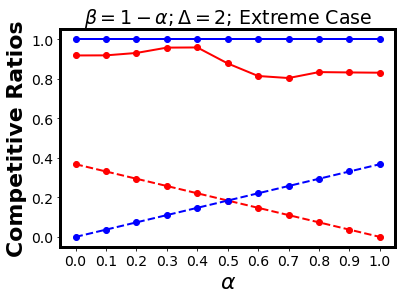

<Figure size 216x216 with 0 Axes>

In [33]:
plot_lines([fairness_crs, [x/np.e for x in 1-alphas], profit_crs, [x/np.e for x in alphas]], 
           [fairness_errors, [0 for x in alphas], profit_errors, [0 for x in alphas]],
            ["{:.1f}".format(x) for x in alphas], alphas, 
           r'$\beta = 1 - \alpha; \Delta = {}$; Extreme Case'.format(driver_quota), 
           r'$\alpha$', 'Competitive Ratios', ['-', '--', '-', '--'], ['red', 'red', 'blue', 'blue'], 
            ['NAdap (fairness)', 'Lower Bound (fairness)', 'NAdap (profit)', 'Lower Bound (profit)'], 
            'plots', 'profit_fairness_crs_vs_alpha_extreme_{}'.format(filename_append), fmt='pdf', separate_legend=True)

## Uniform and Greedy algorithms

In [34]:
uniform_params, greedy_params = [], []
for i in range(num_loops):
    drivers_copy = [copy.deepcopy(d) for d in drivers]
    uniform_params.append([all_requests, drivers_copy, probability_matrix])
for i in range(num_loops):
    drivers_copy = [copy.deepcopy(d) for d in drivers]
    greedy_params.append([all_requests, drivers_copy, probability_matrix, profit_matrix])

In [35]:
with Pool(multiprocessing.cpu_count()) as p:
    uniform_results = p.starmap(run_uniform, uniform_params)

In [36]:
with Pool(multiprocessing.cpu_count()) as p:
    greedy_results = p.starmap(run_greedy, greedy_params)

In [37]:
greedy_profit = 0
for res in greedy_results:
    greedy_profit += res[1]
greedy_profit /= num_loops
greedy_profit_cr = greedy_profit/optimal_profit
greedy_profit_cr

1.0

In [38]:
greedy_fairness_measure_params = []
for i in range(num_loops):
    greedy_fairness_measure_params.append([all_requests, greedy_results[i][0], requests])

with Pool(multiprocessing.cpu_count()) as p:
    greedy_edges_count_results = p.starmap(measure_fairness_edges_count, greedy_fairness_measure_params)

In [39]:
greedy_fairness_cr = calculate_fairness_from_array(greedy_edges_count_results, 
                                                   num_loops, requests)[0]/optimal_fairness
greedy_fairness_cr

0.6174

In [40]:
uniform_profit = 0
for res in uniform_results:
    uniform_profit += res[1]
uniform_profit /= num_loops
uniform_profit_cr = uniform_profit/optimal_profit
uniform_profit_cr

1.0

In [41]:
uniform_fairness_measure_params = []
for i in range(num_loops):
    uniform_fairness_measure_params.append([all_requests, uniform_results[i][0], requests])

with Pool(multiprocessing.cpu_count()) as p:
    uniform_edges_count_results = p.starmap(measure_fairness_edges_count, uniform_fairness_measure_params)

In [42]:
uniform_fairness_cr = calculate_fairness_from_array(uniform_edges_count_results, 
                                                    num_loops, requests)[0]/optimal_fairness
uniform_fairness_cr

0.61605

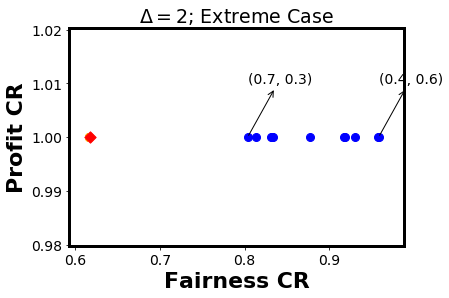

<Figure size 216x216 with 0 Axes>

In [43]:
all_x_vals = [fairness_crs , [uniform_fairness_cr], [greedy_fairness_cr]]
all_y_vals = [profit_crs, [uniform_profit_cr], [greedy_profit_cr]]
labels = [r'$NAdap (\alpha, \beta)$', 'Uniform', 'Greedy']
annotations = ['({:.1f}, {:.1f})'.format(alphas[i], 1-alphas[i]) if \
               i == np.argmin(fairness_crs) or i == np.argmax(fairness_crs)\
               else '' for i in range(len(alphas))] + ['', '']
annotation_positions = [(fairness_crs[i], profit_crs[i] + 0.01) for i in range(len(alphas))]
colors = ['blue', 'orange', 'red']
shapes = ['o', 'X', 'D']
plot_scatter(all_x_vals, all_y_vals, colors, shapes, annotations, annotation_positions,
             r'$\Delta = {}$; Extreme Case'.format(driver_quota), 
             'Fairness CR', 'Profit CR', 'plots', 'fairness_vs_profit_cr_scatter_extreme_{}'.format(filename_append),
            labels=labels, fmt='pdf', separate_legend=True)

### For all other alpha, beta where alpha + beta < 1

In [115]:
remaining_algorithm_params = []
coordinate_to_offset = {}
offset = 0
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            coordinate_to_offset[(alpha_i, beta_j)] = offset
            offset += 1
            for i in range(num_loops):
                remaining_algorithm_params.append([all_requests, [copy.deepcopy(d) for d in drivers],
                                                   probability_matrix, x_f, x_fair, 
                                                   alphas[alpha_i], betas[beta_j]])

In [116]:
with Pool(multiprocessing.cpu_count()) as p:
    remaining_matching_results = p.starmap(run_algorithm, remaining_algorithm_params)

In [117]:
remaining_fairness_measure_params = []
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            for i in range(num_loops):
                remaining_fairness_measure_params.append([all_requests, 
                            remaining_matching_results[coordinate_to_offset[(alpha_i, beta_j)] + i][2], requests])

In [118]:
with Pool(multiprocessing.cpu_count()) as p:
    remaining_edges_count_results = p.starmap(measure_fairness_edges_count, remaining_fairness_measure_params)

In [119]:
for result in remaining_matching_results:
    if result[0] > 0:
        print (remaining_matching_results.index(result))
        print (np.count_nonzero(result[2] != None))

10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10000
1
10000
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1


10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1


10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10000
1
10045
1
10045
1
10045
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10000
1
10045
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1


10011
1
10045
1
10000
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10045
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10045
1
10045
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10000
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1


10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10045
1
10000
1
10045
1
10045
1
10000
1
10011
1
10000
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10000
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10045
1
10045
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10000
1
10000
1
10045
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1


10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10000
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10000
1
10000
1
10000
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10045
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1


10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10000
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10045
1
10011
1
10011
1
10000
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1


10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10000
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1


10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10045
1
10011
1
10045
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1


10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10045
1
10000
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10045
1
10045
1
10000
1
10011
1
10011
1
10045
1
10045
1
10000
1
10045
1
10045
1
10045
1
10045
1
10045
1
10045
1
10045
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10000
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1


10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10045
1
10000
1
10045
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10045
1
10011
1
10045
1
10000
1
10000
1
10000
1
10045
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10000
1
10045
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1


10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10000
1
10045
1
10000
1
10045
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10045
1
10045
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1
10045
1
10045
1
10045
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10045
1
10011
1
10045
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1


10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10045
1
10045
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10045
1
10045
1
10000
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10045
1
10045
1
10000
1
10011
1
10011
1
10000
1
10000
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10045
1
10011
1
10000
1
10045
1
10000
1
10011
1
10000
1
10045
1
10011
1
10000
1
10045
1
10011
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10045
1


10000
1
10011
1
10045
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10045
1
10045
1
10000
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10045
1
10045
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10000
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10045
1
10000
1
10011
1
10045
1
10011
1
10000
1
10000
1
10000
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1


10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10000
1
10011
1
10000
1
10000
1
10000
1
10011
1
10011
1
10045
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10000
1
10045
1
10011
1
10045
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1


1
10011
1
10011
1
10045
1
10045
1
10011
1
10045
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10045
1
10045
1
10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10000
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10045
1
10011
1
10000
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011


1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10000
1
10045
1
10045
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10045
1
10045
1
10045
1
10011


10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10000
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10045
1
10011
1
10045
1
10000
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1


10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10011
1
10045
1
10045
1
10000
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10045
1
10011
1
10045
1
10045
1
10045
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10045
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10000
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10000
1
10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1


10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10000
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10045
1
10011
1
10045
1
10000
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1


10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10011
1
10045
1
10045
1
10000
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10045
1
10011
1
10045
1
10045
1
10045
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10045
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10000
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10000
1
10000
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10000
1
10045
1
10011
1
10011
1
10045
1


10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10000
1
10000
1
10000
1
10000
1
10045
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1


10000
1
10011
1
10011
1
10045
1
10045
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10000
1
10045
1
10045
1
10045
1
10011
1
10000
1
10000
1
10000
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10045
1
10045
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10045
1
10045
1
10045
1
10045
1
10011
1
10000
1
10045
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1


10045
1
10045
1
10011
1
10045
1
10045
1
10000
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10045
1
10000
1
10000
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10000
1
10045
1
10045
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10045
1
10045
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10045
1
10011
1


10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10000
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10000
1
10045
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10000
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1


10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10045
1
10000
1
10000
1
10000
1
10011
1
10045
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10045
1
10045
1
10045
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10000
1
10000
1
10045
1
10011
1
10000
1
10045
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1


10000
1
10011
1
10011
1
10045
1
10000
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10045
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10000
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10045
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10000
1
10011
1
10011
1


10011
1
10011
1
10045
1
10000
1
10045
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10000
1
10000
1
10045
1
10000
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10000
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10045
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10000
1
10045
1


1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10000
1
10045
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10045
1
10000
1
10045
1
10045
1
10011
1
10000
1
10000
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10000
1
10011
1
10045
1
10011
1
10045
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10045
1
10000
1
10045
1
10045
1
10000
1
10011
1
10045
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10000
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10045
1
10045
1
10000
1
10045
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10045
1
10000


10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10000
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10000
1
10000
1
10011
1
10011
1
10045
1
10045
1
10045
1
10000
1
10000
1
10000
1
10045
1
10045
1
10045
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10045
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10045
1
10000
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1


10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1


10045
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10000
1
10000
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10045
1
10045
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1


10045
1
10011
1
10045
1
10011
1
10045
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10000
1
10000
1
10000
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10000
1
10000
1
10000
1
10045
1
10011
1
10045
1
10045
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10045
1
10000
1
10000
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10000
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10000
1
10045
1
10011
1
10011
1


10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10000
1
10045
1
10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10000
1
10045
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10045
1
10000
1
10045
1
10000
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10000
1
10000
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10045
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1


10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10045
1
10045
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1


10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1


10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10000
1
10000
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10045
1
10011
1
10011
1
10045
1
10045
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1
10011
1


10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10045
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10045
1
10011
1
10045
1
10000
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10045
1
10011
1
10045
1
10000
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10000
1
10045
1
10011
1
10000
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10000
1
10045
1
10000
1
10045
1
10011
1
10011
1
10000
1
10000
1
10000
1
10000
1
10000
1
10011
1
10045
1
10045
1
10000
1
10000
1
10011
1
10011
1
10045
1
10000
1


10045
1
10045
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10000
1
10000
1
10000
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10045
1
10011
1
10045
1
10000
1
10000
1
10045
1
10000
1
10011
1
10045
1
10011
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10000
1
10000
1
10000
1
10045
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10000
1
10011
1
10011
1
10000
1
10011
1
10000
1
10045
1
10045
1
10011
1
10000
1
10011
1
10000
1
10011
1
10000
1
10045
1
10000
1
10045
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10045
1
10011
1
10011
1
10045
1
10045
1
10011
1
10000
1
10011
1
10045
1
10000
1
10045
1
10011
1
10045
1
10011
1
10011
1


10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10045
1
10011
1
10011
1
10000
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10000
1
10011
1
10045
1
10045
1
10045
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10000
1
10045
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10000
1
10011
1
10011
1
10011
1
10000
1
10011
1
10011
1
10000
1
10011
1
10000
1
10045
1
10000
1
10000
1
10011
1
10000
1
10045
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10000
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1
10011
1
10045
1
10011
1
10000
1
10011
1
10000
1
10011
1
10045
1
10011
1
10045
1
10011
1
10000
1
10000
1
10011
1
10011
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10000
1
10045
1
10011
1
10045
1
10000
1
10000
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10011
1
10045
1
10011
1


KeyboardInterrupt: 

In [120]:
expected_fairness_map, expected_profit_map = np.full((len(alphas), len(betas)), np.nan), \
                                                np.full((len(alphas), len(betas)), np.nan)
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            offset_index = coordinate_to_offset[(alpha_i, beta_j)]
            assert offset_index*num_loops <= len(remaining_edges_count_results) - num_loops
            
            remaining_fairness_counts = remaining_edges_count_results[offset_index * num_loops:(offset_index+1)*num_loops]
            print ((np.sum(remaining_fairness_counts, axis=0)/num_loops))
            expected_fairness_map[len(alphas) - alpha_i - 1, beta_j] = \
                calculate_fairness_from_array(remaining_fairness_counts, num_loops, requests)/optimal_fairness
            expected_profit = 0
            for i in range(num_loops):
                expected_profit += remaining_matching_results[offset_index + i][0]
            expected_profit /= num_loops
            expected_profit_map[len(alphas) - alpha_i - 1, beta_j] = expected_profit/optimal_profit
#         elif alphas[alpha_i] + betas[beta_j] == 1:
#             expected_fairness_map[len(alphas) - alpha_i - 1, beta_j] = fairness_crs[alpha_i]
#             expected_profit_map[len(alphas) - alpha_i - 1, beta_j] = profit_crs[alpha_i]

[0. 0. 0.]
[0.     0.     0.0001]
[0.     0.     0.0001]
[0.     0.     0.0001]
[0.     0.     0.0001]
[0.     0.     0.0001]
[0.     0.     0.0001]
[0.     0.     0.0001]
[0.     0.     0.0001]
[0.     0.     0.0001]
[0.     0.     0.0001]
[0.     0.     0.0001]
[0.0001 0.     0.0001]
[0.0001 0.     0.0001]
[0.0001 0.     0.0001]
[0.0001 0.     0.0001]
[0.0001 0.     0.0001]
[0.0001 0.     0.0001]
[0.0001 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0002 0.     0.0001]
[0.0003 0.     0.0001]
[0.0004 0.     0.0001]
[0.0004 0.     0.0001]
[0.0004 0.     0.0001]
[0.0004 0.     0.0001]
[0.0004 0.     0.0001]
[0.0004 0.     0.0001]
[0.0004 0.     0.0001]
[0.0004 0.     0.0001]
[0.0004 0.     0.0001]
[0.0005 0.     0.0001]


In [121]:
expected_fairness_map, expected_profit_map

(array([[0.00045,     nan,     nan,     nan,     nan,     nan,     nan,
             nan,     nan,     nan,     nan],
        [0.00045, 0.00045,     nan,     nan,     nan,     nan,     nan,
             nan,     nan,     nan,     nan],
        [0.00045, 0.00045, 0.00045,     nan,     nan,     nan,     nan,
             nan,     nan,     nan,     nan],
        [0.00045, 0.00045, 0.00045, 0.00045,     nan,     nan,     nan,
             nan,     nan,     nan,     nan],
        [0.00045, 0.00045, 0.00045, 0.00045, 0.00045,     nan,     nan,
             nan,     nan,     nan,     nan],
        [0.     , 0.00045, 0.00045, 0.00045, 0.00045, 0.00045,     nan,
             nan,     nan,     nan,     nan],
        [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
             nan,     nan,     nan,     nan],
        [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
         0.     ,     nan,     nan,     nan],
        [0.     , 0.     , 0.     , 0.     , 0.     , 0.

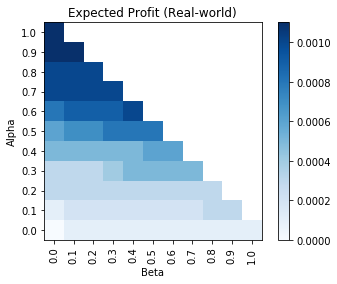

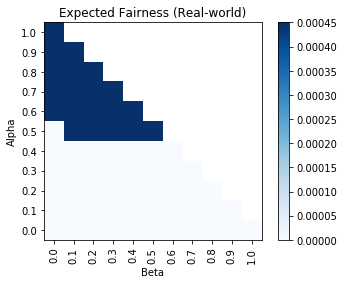

In [122]:
plot_heatmaps([expected_profit_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas[::-1]], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Profit (Real-world)'], subfolder='plots', filename='heatmap_expected_profit_extreme')
plot_heatmaps([expected_fairness_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas[::-1]], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Fairness (Real-world)'], subfolder='plots', filename='heatmap_expected_fairness_extreme')